In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.integrate import simpson
import ipywidgets as widgets

# converts ELECTRON energy in [eV] to wavevector in [1/m]
def e_energy_ev_2k(E):
    return np.sqrt((2*m_e*E)/(hbar**2))

# physical constants
c = 3.0e8                                    # speed of light [m/s]
k_B = 8.617333262145e-5                      # Boltzmann constant [eV/K]
hbar = 6.582119569e-16                       # Reduced Planck constant [eV*s]
m_e = 5.485e-4                               # electron mass [eV*(s/m)^2]

# material constants
E_F = 5.0                                    # Fermi energy [eV]
T_F = E_F/k_B                                # Fermi temperature [K]
k_F = e_energy_ev_2k(E_F)                    # Fermi wavevector [1/m]
a = 4.08e-10                                 # lattice constant [m]

# band structure
E_0V_X = E_F - 1.51                          # [eV]
E_0C_X = E_F + 1.474                         # [eV]

E_0V_L = E_F - 2.38                          # [eV]
E_0C_L = E_F - 0.39                          # [eV]

m_perp_V_L = 0.862*m_e                       # [eV*(s/m)^2]
m_perp_C_L = 0.220*m_e                       # [eV*(s/m)^2]
m_par_V_L = 0.804*m_e                        # [eV*(s/m)^2]
m_par_C_L = 0.251*m_e                        # [eV*(s/m)^2]

m_perp_V_X = 0.7*m_e                         # [eV*(s/m)^2]
m_perp_C_X = 0.231*m_e                       # [eV*(s/m)^2]
m_par_V_X = 0.925*m_e                        # [eV*(s/m)^2]
m_par_C_X = 0.114*m_e                        # [eV*(s/m)^2]

# control parameters
T_e = 300                                    # electron temperature [K]
E_L = 2.25                                   # pump energy [eV]
EF_L = 5e10                                  # pump field strength [V^2/m^2]
EF_sat = 1e13                                # saturation field [V^2/m^2]
delta_E = (abs( EF_L / EF_sat)**2)           # non-thermal distribution factor [a.u.]

In [2]:
# valence band
def E_e(k_par, k_perp, type):
    
    if type == "intra":
        k_e = np.sqrt(k_par**2 + k_perp**2)
        
        return ((hbar*k_e)**2)/(2*m_e)    
    
    # valance band at X
    elif type == "VX":
            
        E_perp = ((hbar*k_perp)**2)/(2*m_perp_V_X)
        E_par = ((hbar*k_par)**2)/(2*m_par_V_X)
    
        return E_0V_X - E_perp - E_par
    
    # valance band at L    
    elif type == "VL":
        
        E_perp = ((hbar*k_perp)**2)/(2*m_perp_V_L)
        E_par = ((hbar*k_par)**2)/(2*m_par_V_L)

        return E_0V_L - E_perp - E_par

    # conduction band at X    
    elif type == "CX":
            
        E_perp = ((hbar*k_perp)**2)/(2*m_perp_C_X)
        E_par = ((hbar*k_par)**2)/(2*m_par_C_X)
    
        return E_0C_X + E_perp - E_par
    
    # conduction band at X 
    elif type == "CL":
        
        E_perp = ((hbar*k_perp)**2)/(2*m_perp_C_L)
        E_par = ((hbar*k_par)**2)/(2*m_par_C_L)

        return E_0C_L + E_perp - E_par



# Fermi-Dirac distribution
def f_T(k_par, k_perp, E_ph, type):
    
    mu = E_F*( 1 - ((np.pi**2)/12)*((T_e/T_F)**2))          # chemical potential
    E = E_e(k_par, k_perp, type) + E_ph - mu                # total energy
    
    return 1 / (np.exp( E / (k_B * T_e)) + 1)

# integrand for the thermal interband emission at X
def j_T_X(k_par, k_perp, E_ph):
    J = 2 * np.pi * k_perp
    return f_T(k_par, k_perp, E_ph, "CX") * (1 - f_T(k_par, k_perp, 0, "VX")) * J

# integrand for the thermal interband emission at L
def j_T_L(k_par, k_perp, E_ph):
    J = 2 * np.pi * k_perp
    return f_T(k_par, k_perp, E_ph, "CL") * (1 - f_T(k_par, k_perp, 0, "VL")) * J

# integrand for the thermal interband emission at L
def j_T_intra(k_par, k_perp, E_ph):
    g1 = 4 * np.pi * k_par**2
    g2 = 4 * np.pi * k_perp**2
    return f_T(k_par, k_perp, E_ph, "intra") * (1 - f_T(k_par, k_perp, 0, "intra")) * g1 * g2

####### NON EQUILIBRIUM #########

# nonthermal distribution
def f_NT_X(k_par, k_perp, E_ph):
    A = f_T(k_par, k_perp, E_ph - E_L, type)*( 1 - f_T(k_par, k_perp, E_ph, type) )
    B = f_T(k_par, k_perp, E_ph, type)*( 1 - f_T(k_par, k_perp, E_ph + E_L, type) )
    return delta_E*(A-B)


# nonthermal distribution
def f_NT_L(k_par, k_perp, E_ph, type):
    A = f_T(k_par, k_perp, E_ph - E_L, type)*( 1 - f_T(k_par, k_perp, E_ph, type) )
    B = f_T(k_par, k_perp, E_ph, type)*( 1 - f_T(k_par, k_perp, E_ph + E_L, type) )
    return delta_E*(A-B)

# nonthermal distribution
def f_NT_intra(k_par, k_perp, E_ph, type):
    A = f_T(k_par, k_perp, E_ph - E_L, type)*( 1 - f_T(k_par, k_perp, E_ph, type) )
    B = f_T(k_par, k_perp, E_ph, type)*( 1 - f_T(k_par, k_perp, E_ph + E_L, type) )
    return delta_E*(A-B)

# nonequilibrium distribution
def f_X(k_par, k_perp, E_ph):
    return f_T(k_par, k_perp, E_ph, ) + f_NT(k_e, E_ph)

# nonequilibrium distribution
def f_L(k_par, k_perp, E_ph):
    return f_T(k_par, k_perp, E_ph) + f_NT(k_e, E_ph)

# nonequilibrium distribution
def f_intra(k_par, k_perp, E_ph):
    return f_T(k_par, k_perp, E_ph) + f_NT(k_e, E_ph)


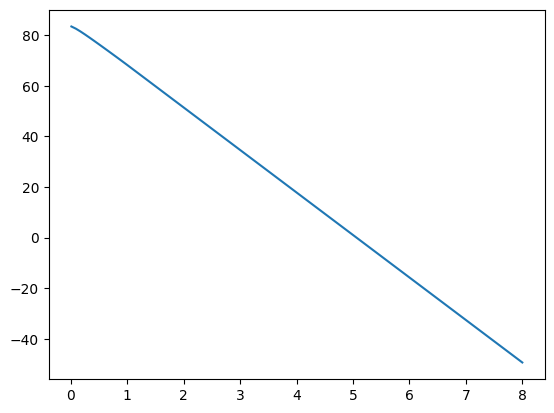

In [3]:
k_max = e_energy_ev_2k(10) 
k_par = np.linspace(-k_F, k_F, 10000)
k_perp = np.linspace(0, k_F, 5000)
K_par, K_perp = np.meshgrid(k_par, k_perp)


def I_e_T_intra(E_ph):
    J = j_T_intra(K_par, K_perp, E_ph)
    
    int_J_k_perp = simpson(J, k_perp, axis = 0)
    int_J_k_perp_k_par = simpson(int_J_k_perp, k_par)
    
    return int_J_k_perp_k_par

# takes about 3 minutes for 100 points
E_ph_vals = np.linspace(0.01, 8.0, 100)
I_e_T_numeric_vals = np.array( [I_e_T_intra(E_ph) for E_ph in E_ph_vals] )
plt.plot(E_ph_vals, np.log10(I_e_T_numeric_vals))

In [4]:
np.savetxt("/Users/ben/Desktop/I_e_T_momentum_integral.csv", I_e_T_numeric_vals, delimiter=",", fmt='%d')